In [0]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# https://drive.google.com/open?id=1wWRxTCgIsk0HlOI9ABvjsD0OFz-1CiIh
# https://drive.google.com/open?id=1wWRxTCgIsk0HlOI9ABvjsD0OFz-1CiIh
# https://drive.google.com/open?id=1ax66OPpL5s90hSpCIokEpketijCNJt1j
# https://drive.google.com/open?id=1aNlJ6x5DXfkjEW9ML_Yuc0LPWxvsnis6
# https://drive.google.com/open?id=15IDIRfLy2D0YgD4It3b4yK9D8EiXu5U6
file_id = '1wWRxTCgIsk0HlOI9ABvjsD0OFz-1CiIh'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
downloaded.GetContentFile('h1_b.csv')

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [270]:
df = pd.read_csv('h1_b.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16,17,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df.drop(labels=['PUBLIC_DISCLOSURE_LOCATION'], axis=1, inplace=True)
df.drop(labels=['CASE_NUMBER'], axis=1, inplace=True)
df = df[(df['CASE_SUBMITTED'] < '2017-06-30') & (df['CASE_SUBMITTED'] > '2016-10-01')]

In [0]:
X = df.drop(labels=['CASE_STATUS'], axis=1)
y = df['CASE_STATUS']
y = y.replace({'WITHDRAWN':0, 'DENIED':0, 'CERTIFIED':1, 'CERTIFIED-WITHDRAWN':1})
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [0]:
missing_columns = X_train.isnull().sum()[X_train.isnull().sum() > 0].index
for col in missing_columns:
  X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
for col in missing_columns:
  X_test[col] = X_test[col].fillna(X_train[col].mode()[0])

In [0]:
le = LabelEncoder()

In [0]:
cat_columns = set(X_train.columns) - set(X_train.select_dtypes(exclude='object').columns)

In [0]:
# X_train['EMPLOYER_ADDRESS']  = X_train['EMPLOYER_ADDRESS'].str.replace(' ', '')

In [0]:
X_train = X_train[cat_columns].astype(str)
X_test = X_test[cat_columns].astype(str)

In [0]:
for col in cat_columns:
#   print(col)
  X_train[col] = le.fit_transform(X_train[col])

In [0]:
for col in cat_columns:
#   print(col)
  X_test[col] = le.fit_transform(X_test[col])

In [0]:
kBest = SelectKBest(score_func = f_classif, k=30)

In [0]:
X_train = kBest.fit_transform(X_train, y_train)
X_test = kBest.fit_transform(X_test, y_test)

In [312]:
X_train.shape

(377409, 30)

In [0]:
clf_dt = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30, random_state=0)

In [0]:
def buildModel(clf, class_weigths=None):
  clf.fit(X_train, y_train, sample_weight=class_weigths)
  y_pred = clf.predict(X_test)
  getMetricsScores(y_test, y_pred)

In [0]:
def getMetricsScores(y_test, y_pred):
  print("ROC Score: {}".format(roc_auc_score(y_test, y_pred)))
  print("F1 Score:{}".format(f1_score(y_test, y_pred)))
  print("Accuracy Score : {}".format(accuracy_score(y_test, y_pred)))
  print("Recall Score : {}".format(recall_score(y_test, y_pred)))
  print("Precision score:{}".format(precision_score(y_test, y_pred)))
#   print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

In [350]:
buildModel(clf_dt)

ROC Score: 0.5041568023244105
F1 Score:0.9773049818431723
Accuracy Score : 0.9556373406250993
Recall Score : 0.9976753067764808
Precision score:0.9577498465732025
[[    57   5301]
 [   280 120166]]


In [0]:

from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [0]:
buildModel(rfc)

In [0]:
from sklearn.utils import class_weight
import numpy as np

In [0]:
class_wt = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [335]:
buildModel(clf_dt, class_wt)

ValueError: ignored

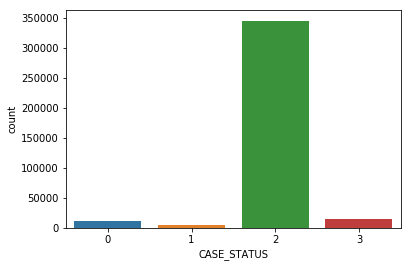

In [286]:
sns.countplot(y_train)

In [195]:
df['CASE_STATUS'].value_counts()

CERTIFIED              461052
CERTIFIED-WITHDRAWN     20528
WITHDRAWN               14682
DENIED                   6951
Name: CASE_STATUS, dtype: int64

In [222]:
df.head()

,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
16,WITHDRAWN,2016-10-02,2016-10-02,H-1B,2016-10-08,2019-10-07,ITAS INC,NaN,8888 KEYSTONE CROSSING,INDIANAPOLIS,...,Year,N,N,NaN,Y,MELVILLE,SUFFOLK,NY,11747,NaN
1501,WITHDRAWN,2016-10-03,2016-10-03,H-1B,2016-10-03,2019-09-01,THRIVESOFT INC,SANTHA YAKKALI,22623 44TH DR SE,BOTHELL,...,Year,Y,N,Y,Y,BELLEVUE,KING,WA,98007,NaN
1502,WITHDRAWN,2016-10-03,2016-10-03,H-1B,2016-10-03,2019-10-02,"BOSS TECHNOLOGIES, INC",NaN,5755 NORTH POINT PARKWAY,ALPHARETTA,...,Year,Y,N,Y,NaN,ALPHARETTA,GEORGIA,GA,30022,NaN
1503,WITHDRAWN,2016-10-03,2016-10-03,H-1B,2016-10-11,2019-10-10,INVENTIV HEALTH CLINICAL LLC,NaN,202 CARNEGIE CENTER,PRINCETON,...,Year,N,N,NaN,Y,PRINCETON,MERCER,NJ,08540,NaN
1504,WITHDRAWN,2016-10-03,2016-10-03,H-1B,2016-10-10,2017-05-08,SOFTPATH SYSTEM LLC,NaN,3985 STEVE REYNOLDS BLVD.,NORCROSS,...,Year,Y,N,Y,NaN,HARTFORD,HARTFORD,CT,06103,NaN


In [226]:
df.shape[0]-df['ORIGINAL_CERT_DATE'].isnull().sum()

20532

In [0]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()

In [0]:
le.fit(X_train, y_train)

In [231]:
X = SelectKBest(score_func = chi2, k=40).fit_transform(X, y)

ValueError: ignored

In [225]:
df[df['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN'].shape

(20528, 50)

In [0]:
X = df.drop(labels=['CASE_STATUS'], axis=1)
y = df['CASE_STATUS']

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468487 entries, 220009 to 305711
Data columns (total 50 columns):
CASE_NUMBER                    468487 non-null object
CASE_SUBMITTED                 468487 non-null object
DECISION_DATE                  468487 non-null object
VISA_CLASS                     468487 non-null object
EMPLOYMENT_START_DATE          468487 non-null object
EMPLOYMENT_END_DATE            468487 non-null object
EMPLOYER_NAME                  468487 non-null object
EMPLOYER_BUSINESS_DBA          468487 non-null object
EMPLOYER_ADDRESS               468487 non-null object
EMPLOYER_CITY                  468487 non-null object
EMPLOYER_STATE                 468487 non-null object
EMPLOYER_POSTAL_CODE           468487 non-null object
EMPLOYER_COUNTRY               468487 non-null object
EMPLOYER_PROVINCE              468487 non-null object
EMPLOYER_PHONE                 468487 non-null object
EMPLOYER_PHONE_EXT             468487 non-null object
AGENT_REPRESENTING_E

In [0]:
num_cols = X_train.describe().columns

In [136]:
df[num_cols].head()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,PREVAILING_WAGE,PW_SOURCE_YEAR,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO
0,1,1,0,0,0,0,0,59197.0,2015.0,65811.0,67320.0
1,1,1,0,0,0,0,0,49800.0,2015.0,53000.0,57200.0
2,2,2,0,0,0,0,0,76502.0,2015.0,77000.0,0.0
3,1,1,0,0,0,0,0,90376.0,2016.0,102000.0,0.0
4,1,0,0,0,0,1,0,116605.0,2015.0,132500.0,0.0


In [0]:
missing_columns = X_train.isnull().sum()[X_train.isnull().sum() > 0].index
missing_columns
for col in missing_columns:
  df[col] = df[col].fillna(df[col].mode()[0])

In [0]:
df.isnull().sum()

In [0]:
X = df.drop(labels=['CASE_STATUS'], axis=1)
y = df['CASE_STATUS']

In [0]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [0]:
numeric_columns = X_train._get_numeric_data().columns

In [0]:
categorical_columns = list(set(X_train.columns) - set(numeric_columns))

In [106]:
X_train[categorical_columns].head()

,CASE_NUMBER,EMPLOYER_ADDRESS,WORKSITE_STATE,EMPLOYER_BUSINESS_DBA,EMPLOYER_PHONE_EXT,AGENT_ATTORNEY_NAME,H1B_DEPENDENT,WORKSITE_COUNTY,EMPLOYER_POSTAL_CODE,AGENT_REPRESENTING_EMPLOYER,...,AGENT_ATTORNEY_CITY,SOC_CODE,JOB_TITLE,ORIGINAL_CERT_DATE,EMPLOYER_PROVINCE,FULL_TIME_POSITION,SOC_NAME,EMPLOYER_COUNTRY,AGENT_ATTORNEY_STATE,WORKSITE_CITY
220009,I-200-17060-295468,9201 CORPORATE BOULEVARD,TX,NaN,226,",",Y,COLLIN,20850,N,...,NaN,15-1131,DEVELOPER,NaN,NaN,Y,COMPUTER PROGRAMMERS,UNITED STATES OF AMERICA,NaN,PLANO
165846,I-200-14337-126695,134 COLUMBIA COURT,MN,NaN,NaN,"MAXWELL, GEORGE",N,CARVER,55318,Y,...,MINNEAPOLIS,17-2112,INDUSTRIAL ENGINEER,2015-02-27,NaN,Y,INDUSTRIAL ENGINEERS,UNITED STATES OF AMERICA,MN,CHASKA
164082,I-200-17039-629236,MORRIS CORP. CENTER IV,PA,NaN,NaN,"CHIAPPARI, TED",N,CUMBERLAND,07054-0225,Y,...,NEW YORK,13-1161,ANALYST,NaN,NaN,Y,MARKET RESEARCH ANALYSTS AND MARKETING SPECIAL...,UNITED STATES OF AMERICA,NY,CAMP HILL
341261,I-200-17069-665496,13000 PIERCE STREET,FL,NaN,NaN,"SIMMONS, TERI",N,BREVARD,91331,Y,...,ATLANTA,15-1199,CONTROLS ENGINEER,NaN,NaN,Y,"COMPUTER OCCUPATIONS, ALL OTHER",UNITED STATES OF AMERICA,GA,MELBOURNE
243938,I-200-17065-735517,1551 SOUTH WASHINGTON AVENUE,CA,NaN,NaN,",",Y,SANTA CLARA,08854,N,...,NaN,15-1131,PROGRAMMER ANALYST,NaN,MIDDLESEX,Y,COMPUTER PROGRAMMERS,UNITED STATES OF AMERICA,NaN,MILPITAS


In [95]:
X_train.isnull().sum()

CASE_NUMBER                         0
CASE_SUBMITTED                      0
DECISION_DATE                       0
VISA_CLASS                          0
EMPLOYMENT_START_DATE              19
EMPLOYMENT_END_DATE                20
EMPLOYER_NAME                      50
EMPLOYER_BUSINESS_DBA          436162
EMPLOYER_ADDRESS                    5
EMPLOYER_CITY                      11
EMPLOYER_STATE                     15
EMPLOYER_POSTAL_CODE               13
EMPLOYER_COUNTRY                72290
EMPLOYER_PROVINCE              463873
EMPLOYER_PHONE                  72291
EMPLOYER_PHONE_EXT             447554
AGENT_REPRESENTING_EMPLOYER     72289
AGENT_ATTORNEY_NAME                 0
AGENT_ATTORNEY_CITY            204772
AGENT_ATTORNEY_STATE           216378
JOB_TITLE                           4
SOC_CODE                            2
SOC_NAME                            3
NAICS_CODE                          6
TOTAL_WORKERS                       0
NEW_EMPLOYMENT                      0
CONTINUED_EM

In [146]:
X_train.head()

,CASE_NUMBER,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
220009,I-200-17060-295468,2017-03-01,2017-03-07,H-1B,2017-08-28,2020-08-27,TATA CONSULTANCY SERVICES LIMITED,"MASTECH DIGITAL TECHNOLOGIES, INC.",9201 CORPORATE BOULEVARD,ROCKVILLE,...,Year,Y,N,Y,Y,PLANO,COLLIN,TX,75024,2017-03-16
165846,I-200-14337-126695,2015-02-23,2017-02-21,H-1B,2015-08-02,2018-08-01,"PACA, INC.","MASTECH DIGITAL TECHNOLOGIES, INC.",134 COLUMBIA COURT,CHASKA,...,Year,N,N,Y,Y,CHASKA,CARVER,MN,55318,2015-02-27
164082,I-200-17039-629236,2017-02-13,2017-02-17,H-1B,2017-08-08,2020-08-08,RECKITT BENCKISER LLC,"MASTECH DIGITAL TECHNOLOGIES, INC.",MORRIS CORP. CENTER IV,PARSIPPANY,...,Year,N,N,Y,Y,CAMP HILL,CUMBERLAND,PA,17011,2017-03-16
341261,I-200-17069-665496,2017-03-17,2017-03-23,H-1B,2017-09-09,2020-09-08,"SDI INDUSTRIES, INC.","MASTECH DIGITAL TECHNOLOGIES, INC.",13000 PIERCE STREET,PACOIMA,...,Year,N,N,Y,Y,MELBOURNE,BREVARD,FL,32901,2017-03-16
243938,I-200-17065-735517,2017-03-06,2017-03-10,H-1B,2017-07-11,2020-07-10,"FIRST TEK, INC.","MASTECH DIGITAL TECHNOLOGIES, INC.",1551 SOUTH WASHINGTON AVENUE,PISCATAWAY,...,Year,Y,N,Y,Y,MILPITAS,SANTA CLARA,CA,95035,2017-03-16


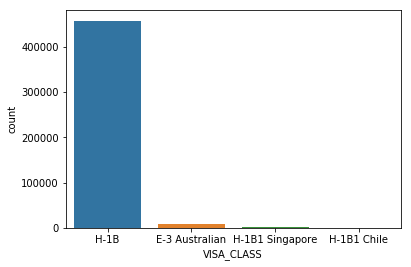

In [163]:
sns.countplot(X_train.VISA_CLASS)
plt.show()

(503213, 51)

In [188]:
df.shape

(624650, 51)

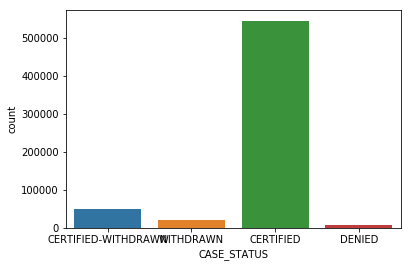

In [82]:
import seaborn as sns
sns.countplot(y)
plt.show()

In [85]:
X_train['EMPLOYER_BUSINESS_DBA'].unique()

array([nan, 'NOVARTIS PHARMACEUTICALS CORPORATION', 'CAREERBUILDER', ...,
       'ALAGASCO', 'BORIES AND SHEARRON', 'AMAZING STUFF SHOP'],
      dtype=object)